This is an example notebook for fitting a generative model to find the consensus spot locations from annotations sets from various "classical" spot detection algoritms. We assume that the consensus between these classical annotation sets is more correct than any of the individual annotations sets. Therefore, we can use this consensus annotation set will be higher quality training data from a deep learning model for spot detection than any of the individual classical annotation set.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
import os
import errno
from deepcell_spots.spot_em import *
from deepcell_spots.cluster_vis import *
from deepcell_spots.postprocessing_utils import *

# Load example data

In [2]:
data_dir = '/data/example_data/'
coords_files = glob.glob(data_dir + '*coords*.npy')
coords_files

['/data/example_data/plm_coords.npy',
 '/data/example_data/dog_coords.npy',
 '/data/example_data/log_coords.npy',
 '/data/example_data/trackpy_coords.npy']

In [3]:
image_files = glob.glob(data_dir + '*image*')
image_files

['/data/example_data/image_stack.npy']

In [4]:
# Load each of the individual classical annotations sets
plm_coords = np.load(coords_files[0], allow_pickle=True)
log_coords = np.load(coords_files[1], allow_pickle=True)
dog_coords = np.load(coords_files[2], allow_pickle=True)
trackpy_coords = np.load(coords_files[3], allow_pickle=True)

# Load the associated images
image_stack = np.load(image_files[0], allow_pickle=True)

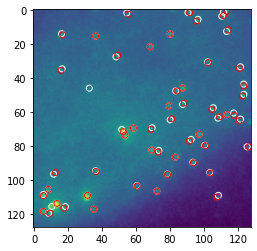

In [5]:
# Visualize to ensure that data loaded correctly
ind=2

plt.imshow(image_stack[ind])
plt.scatter(trackpy_coords[ind][:,1],trackpy_coords[ind][:,0],facecolors='None',edgecolors='w')
plt.scatter(plm_coords[ind][:,1],plm_coords[ind][:,0],facecolors='None',edgecolors='r')
plt.show()

# Cluster detections

The detections from each of the annotation sets are first grouped into clusters of detections presumed to be derived from the same ground truth detection. The users can set a distance threshold (in pixels), and detections closer than the set threshold will be assigned to the same clusters. The clusters may only contain one detection from each annotator, and if there are more than one, only the detection closest to the centroid of the cluster is kept and all others are removed into new clusters. Images with no detected clusters are removed at this step.

In this step, the `cluster_coords` function outputs a `cluster_matrix`, which has the dimensions (number of clusters)x(number of annotators) and has a value of 1 if a particular annotator found that cluster and 0 if it did not. This matrix is a required input for the expectation maximization function `em_spot`. The function also outputs `centroid_list`, which is a list of the centroid locations for each of the clusters, and `all_coords_updated` and `image_stack_updated` which are the same as the inputs `all_coords` and `image_stack` except for the dropped images with no detected clusters. 

In [6]:
all_coords = [log_coords,dog_coords,plm_coords,trackpy_coords]
dist_thresh = 2 # distance threshold for clustering points

cluster_matrix, centroid_list, all_coords_updated, image_stack_updated = cluster_coords(all_coords,image_stack,dist_thresh)

/usr/local/lib/python3.6/dist-packages/deepcell_spots/spot_em.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array([item[0] for item in all_coords])
/usr/local/lib/python3.6/dist-packages/deepcell_spots/spot_em.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array([item[i] for item in all_coords])


In [18]:
np.shape(all_coords_updated), np.shape(image_stack_updated)

((4, 722), (722, 128, 128, 1))

In [20]:
np.shape(p_matrix_all)

(16952, 2)

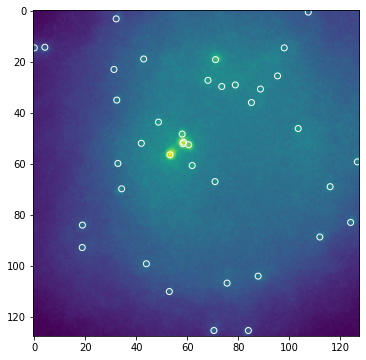

In [7]:
# Visualize cluster locations
ind=0

plt.figure(figsize=(6,6))
plt.imshow(image_stack[ind])
plt.scatter(centroid_list[ind][:,1],centroid_list[ind][:,0],facecolors='None',edgecolors='w')
plt.show()

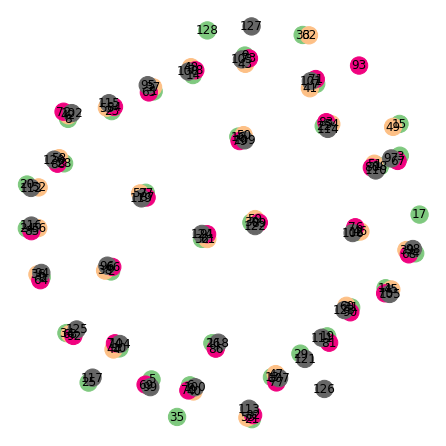

In [8]:
# Visualize clusters as a graph
running_total = running_total_spots(centroid_list)
data = cluster_matrix[running_total[ind]:running_total[ind+1]]

A = ca_to_adjacency_matrix(data)

G=nx.from_numpy_matrix(A)

G.add_node(len(G.nodes),pos=(0,0)) 
G.nodes[len(G.nodes)-1]['name'] = 0  

G_labeled = label_graph_ann(G, [all_coords[0][ind],all_coords[1][ind],all_coords[2][ind],all_coords_updated[3][ind]],exclude_last=True)
pos = nx.spring_layout(G_labeled)

plt.figure(figsize=(6,6))
nx.draw(G_labeled, pos=pos, node_color = list(nx.get_node_attributes(G_labeled,'name').values()), with_labels=True, edge_color='black', cmap=plt.cm.Accent)
# plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Accent))
plt.show()

# Expectation maximization

Next, we estimate the probability that each of the clusters is a true detection with expectation maximization (EM). The EM function `em_spot` requires the `cluster_matrix` output from `cluster_coords`, a guess for the true positive rate (TPR) and false positive rate (FPR) of each annotator, and a guess for the prior probability that each detection is a true detection. The algorithm is relatively robust to the initial TPR and FPR guesses, converging to the same values regardless of input. However, the algorithm output probabilities will scale with the input prior probability, so it needs to be selected with more care. The user can also set the maximum number of iterations the EM algorithm performs.

In [9]:
# Expectation maximization

tp_guess = [0.9,0.9,0.9,0.9]
fp_guess = [0.1,0.1,0.1,0.1]
prior = 0.9

tp_final_all, fp_final_all, p_matrix_all = em_spot(cluster_matrix, tp_guess, fp_guess, prior, max_iter=15)

In [10]:
print('True positive rate for PLM: ' + str(tp_final_all[0]))
print('True positive rate for LoG: ' + str(tp_final_all[1]))
print('True positive rate for DoG: ' + str(tp_final_all[2]))
print('True positive rate for TrackPy: ' + str(tp_final_all[3]))

True positive rate for PLM: 0.9758917556083768
True positive rate for LoG: 0.9787419706483725
True positive rate for DoG: 0.9672639601819732
True positive rate for TrackPy: 0.971548285449452


In [11]:
print('False positive rate for PLM: ' + str(fp_final_all[0]))
print('False positive rate for LoG: ' + str(fp_final_all[1]))
print('False positive rate for DoG: ' + str(fp_final_all[2]))
print('False positive rate for TrackPy: ' + str(fp_final_all[3]))

False positive rate for PLM: 0.3344179005351393
False positive rate for LoG: 0.4510454915574746
False positive rate for DoG: 0.3922619248600679
False positive rate for TrackPy: 0.33477334893634036


In [12]:
ind = 2
running_index = np.arange(running_total[ind], running_total[ind+1])

print('Image {} has clusters {} through {}'.format(ind,running_index[0],running_index[-1]))
print('Cluster {} has a {}% probability of being a true detection'.format(running_index[0],p_matrix_all[running_index[0]][0]*100))

Image 2 has clusters 74 through 132
Cluster 74 has a 100.0% probability of being a true detection


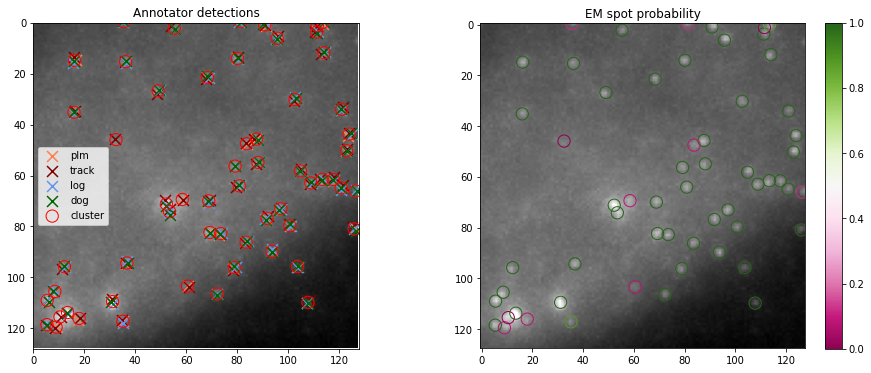

In [13]:
# Visualize EM output probabilities
size = 120
jitter_size = 0.3
centroid_list = [np.array(item) for item in centroid_list]
ind = 2
vmax=0.9
cmap = plt.cm.PiYG

fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(image_stack_updated[ind],cmap='gray', vmax=vmax)
ax[0].scatter(all_coords_updated[2][ind][:,1],all_coords_updated[2][ind][:,0], marker='x', c='coral', s=size, label='plm')
ax[0].scatter(jitter(all_coords_updated[3][ind][:,1],jitter_size),jitter(all_coords_updated[3][ind][:,0],jitter_size), marker='x', c='maroon', s=size, label='track')
ax[0].scatter(jitter(all_coords_updated[0][ind][:,1],jitter_size),jitter(all_coords_updated[0][ind][:,0],jitter_size), marker='x', c='cornflowerblue', s=size, label='log')
ax[0].scatter(jitter(all_coords_updated[1][ind][:,1],jitter_size),jitter(all_coords_updated[1][ind][:,0],jitter_size), marker='x', c='darkgreen', s=size, label='dog')
ax[0].scatter(centroid_list[ind][:,1], centroid_list[ind][:,0], edgecolors='r', facecolors='None', s=150, label='cluster')
ax[0].legend()
ax[0].set_title('Annotator detections')
ax[0].set_xlim([0,128])
ax[0].set_ylim([128,0])

running_index = np.arange(running_total[ind], running_total[ind+1])

ax[1].imshow(image_stack_updated[ind], cmap='gray',vmax=vmax)
for i in range(len(centroid_list[ind])):
    ax[1].scatter(centroid_list[ind][:,1][i], centroid_list[ind][:,0][i], edgecolors=cmap(p_matrix_all[:,0][running_index[i]]), facecolors='None', s=150, label='cluster')
ax[1].set_title('EM spot probability')
# ax[1].set_xlim([40,100])
# ax[1].set_ylim([110,50])

norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap='PiYG', norm=norm)
sm.set_array([])
plt.colorbar(sm)

plt.show()

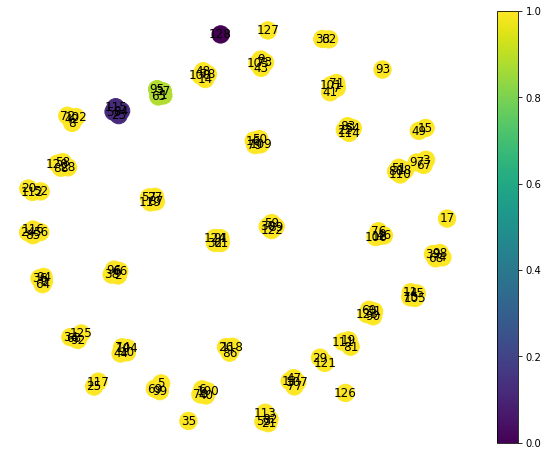

In [14]:
# Visualize EM output as a graph
p_matrix = p_matrix_all[running_total[ind]:running_total[ind+1]]

G_labeled = label_graph_prob(G, data, p_matrix)

plt.figure(figsize=(8,6))
nx.draw(G_labeled, pos=pos, node_color = list(nx.get_node_attributes(G_labeled,'name').values()), with_labels=True, edge_color='black', cmap=plt.cm.viridis)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis))
plt.show()

# Create consensus annotation set

In [15]:
y = consensus_coords(p_matrix_all,centroid_list,running_total)

np.shape(y)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(720,)

In [23]:
# Removing images and corresponding coordinates with low number of spots
X_keep = []
y_keep = []
min_num_spots=8

for i in range(len(y)):
    if len(y[i]) > 0:
        max_int = np.round(max(map(max,y[i])))

        if max_int == 128:
            continue
        if len(y[i]) > min_num_spots:
            X_keep.append(image_stack_updated[i])
            y_keep.append(y[i])
            
y_keep=np.array([np.array(item) for item in y_keep])
np.shape(X_keep), np.shape(y_keep)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


((614, 128, 128, 1), (614,))

In [24]:
np.savez('/data/example_data/em_output.npz', X=X_keep, y=y_keep)